In [2]:
#Bibliotecas 
import yfinance as yf 
import pandas as pd    
import numpy as np    
import matplotlib.pyplot as plt 
import seaborn as sns 
from datetime import datetime, timedelta  
import warnings
import json
import pickle
import time
import os
from typing import Tuple, Dict, List, Optional

# Ignorar avisos para manter o notebook limpo
warnings.filterwarnings('ignore')

# Configurar visualizações
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Deep Learning com PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F

# Otimização de hiperparâmetros
import optuna

# Verificar se temos GPU disponível
print(f"CUDA disponível (GPU): {torch.cuda.is_available()}")

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")




CUDA disponível (GPU): True


In [3]:
#Coleta de Dados 

SYMBOL = 'PETR4.SA'  # Símbolo da ação da Petrobras
START_DATE = '2018-01-01'  # Data de início
END_DATE = '2026-01-01'  # Data final fixa para consistência


# Baixar dados históricos
df = yf.download(SYMBOL, start=START_DATE, end=END_DATE, progress=False)

# Verificar se os dados foram baixados
if df.empty:
    print("ERRO: Nenhum dado encontrado!")
else:
    print(f"Dados baixados com sucesso!")

# Manter apenas a coluna de fechamento
df_close = df[['Close']].copy()

Dados baixados com sucesso!


Primeiras 10 linhas:
Price          Close
Ticker      PETR4.SA
Date                
2018-01-02  4.410662
2018-01-03  4.450639
2018-01-04  4.458633
2018-01-05  4.485283
2018-01-08  4.538585
2018-01-09  4.538585
2018-01-10  4.477288
2018-01-11  4.597216
2018-01-12  4.610542
2018-01-15  4.623868

Últimas 10 linhas:
Price           Close
Ticker       PETR4.SA
Date                 
2025-12-15  30.738596
2025-12-16  29.807711
2025-12-17  30.137400
2025-12-18  29.962858
2025-12-19  30.069523
2025-12-22  30.156794
2025-12-23  30.309999
2025-12-26  30.410000
2025-12-29  30.730000
2025-12-30  30.820000


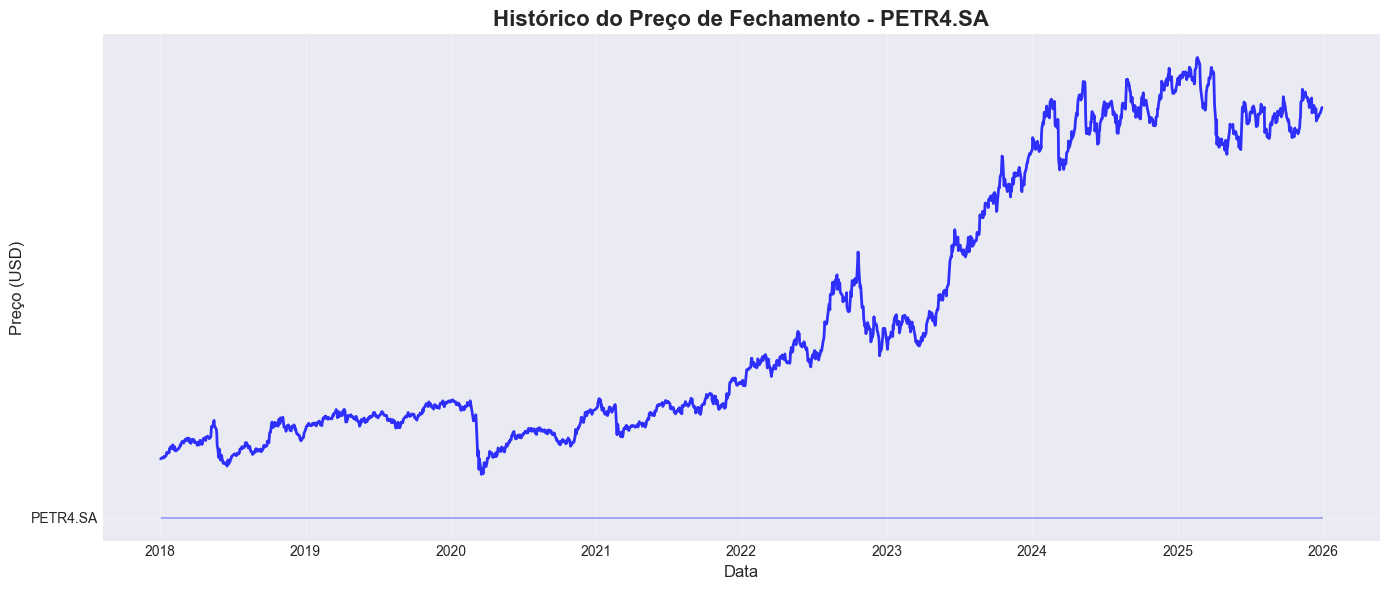

In [4]:
#Visualização de Dados 

# Mostrar primeiras e últimas linhas
print("Primeiras 10 linhas:")
print(df_close.head(10))
print("\nÚltimas 10 linhas:")
print(df_close.tail(10))

# Gráfico do histórico de preços
plt.figure(figsize=(14, 6))
plt.plot(df_close.index, df_close['Close'], linewidth=2, color='blue', alpha=0.8)
plt.title(f'Histórico do Preço de Fechamento - {SYMBOL}', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.fill_between(df_close.index, [val for val in df_close['Close']], alpha=0.3, color='blue')
plt.tight_layout()
plt.show()

In [5]:
#Pré-processamento dos Dados

# Separar os valores de fechamento
close_prices = df_close['Close'].values.reshape(-1, 1)
print(f"Formato dos dados originais: {close_prices.shape}")
print(f"Primeiros 5 valores: {close_prices[:5].flatten()}")
print(f"Últimos 5 valores: {close_prices[-5:].flatten()}")

# Normalizar os dados (escala 0 a 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(close_prices)

print(f" Dados normalizados:")
print(f"Primeiros 5 valores escalados: {scaled_prices[:5].flatten().round(4)}")
print(f"Últimos 5 valores escalados: {scaled_prices[-5:].flatten().round(4)}")



Formato dos dados originais: (1988, 1)
Primeiros 5 valores: [4.41066217 4.45063925 4.45863342 4.48528337 4.53858519]
Últimos 5 valores: [30.15679359 30.30999947 30.40999985 30.72999954 30.81999969]
 Dados normalizados:
Primeiros 5 valores escalados: [0.0373 0.0385 0.0388 0.0396 0.0413]
Últimos 5 valores escalados: [0.8588 0.8637 0.8669 0.8771 0.88  ]


In [6]:
#Criando Sequências para LSTM

def create_sequences(data, sequence_length):
    """
    Cria sequências para treinamento LSTM
    
    Args:
        data: array de dados normalizados
        sequence_length: quantos dias usamos para prever o próximo
    
    Returns:
        X: sequências de entrada [samples, sequence_length, features]
        y: valores alvo [samples]
    """
    X, y = [], []
    
    for i in range(len(data) - sequence_length):
        # Pegar sequência de 'sequence_length' dias
        seq = data[i:(i + sequence_length)]
        # Próximo valor é o alvo
        target = data[i + sequence_length]
        
        X.append(seq)
        y.append(target)
    
    return np.array(X), np.array(y)

# Criar sequências
SEQUENCE_LENGTH = 60  
X, y = create_sequences(scaled_prices, SEQUENCE_LENGTH)


print(f"Comprimento da sequência: {SEQUENCE_LENGTH} dias")
print(f"Formato de X (entrada): {X.shape}")  # (amostras, sequência, features)
print(f"Formato de y (saída): {y.shape}")    # (amostras,)
print(f"\nTotal de amostras disponíveis: {len(X)}")
print(f"Período coberto: {len(X)} dias de previsão")



Comprimento da sequência: 60 dias
Formato de X (entrada): (1928, 60, 1)
Formato de y (saída): (1928, 1)

Total de amostras disponíveis: 1928
Período coberto: 1928 dias de previsão


In [7]:
# Divisão dos Dados
# Treino: 80%
# Validação: 10%
# Teste: 10%

def split_data(X, y, train_ratio, val_ratio):
    """
    Divide os dados em treino, validação e teste
    
    Args:
        X: dados de entrada
        y: dados de saída
        train_ratio: proporção para treino
        val_ratio: proporção para validação
    
    Returns:
        Dicionário com os dados divididos
    """
    total_samples = len(X)
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)
    
    # Divisão
    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]
    
    return {
        'train': (X_train, y_train),
        'val': (X_val, y_val),
        'test': (X_test, y_test)
    }

# Aplicar divisão
data_split = split_data(X, y, train_ratio=0.8, val_ratio=0.1)


# Imprimir tamanhos
for split_name, (X_split, y_split) in data_split.items():
    print(f"{split_name.upper():10s}: {len(X_split):4d} amostras "
          f"({len(X_split)/len(X)*100:.1f}%)")

# Preparar dados para PyTorch
X_train, y_train = data_split['train']
X_val, y_val = data_split['val']
X_test, y_test = data_split['test']

# Converter para tensores PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

TRAIN     : 1542 amostras (80.0%)
VAL       :  192 amostras (10.0%)
TEST      :  194 amostras (10.1%)


In [8]:
#Criação de Datasets e DataLoaders

class StockDataset(Dataset):
    """Dataset personalizado para dados de ações"""
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# Criar datasets
train_dataset = StockDataset(X_train_tensor, y_train_tensor)
val_dataset = StockDataset(X_val_tensor, y_val_tensor)
test_dataset = StockDataset(X_test_tensor, y_test_tensor)


# Criar DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [9]:
#Definição do Modelo LSTM

class LSTMModel(nn.Module):
    """
    Modelo LSTM para previsão de séries temporais
    
    Args:
        input_size: número de features (1 para preço de fechamento)
        hidden_size: número de neurônios LSTM
        num_layers: número de camadas LSTM
        dropout: taxa de dropout para regularização
    """
    
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Camada LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Camada dropout para regularização
        self.dropout = nn.Dropout(dropout)
        
        # Camada fully connected para saída
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        """
        Forward pass do modelo
        
        Args:
            x: tensor de entrada [batch_size, sequence_length, input_size]
        
        Returns:
            Previsão do próximo valor
        """
        # Inicializar estados ocultos
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Passar pela LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Pegar apenas a última saída da sequência
        lstm_out = lstm_out[:, -1, :]
        
        # Aplicar dropout
        lstm_out = self.dropout(lstm_out)
        
        # Camada fully connected
        output = self.fc(lstm_out)
        
        return output


# Criar modelo
model = LSTMModel(
    input_size=1,      # 1 feature (preço de fechamento)
    hidden_size=50,    # 50 neurônios LSTM
    num_layers=2,      # 2 camadas LSTM
    dropout=0.2        # 20% dropout
)


model = model.to(device)

print(f"ARQUITETURA DO MODELO:")
print(model)



ARQUITETURA DO MODELO:
LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [10]:
class ModelTrainer:
    """Classe para treinamento do modelo"""
    
    def __init__(self, model, train_loader, val_loader, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        
        # Definir função de perda e otimizador
        self.criterion = nn.MSELoss()  # Erro quadrático médio
        self.optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=5, factor=0.5
        )
        
        # Histórico de treinamento
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'learning_rate': []
        }
    
    def train_epoch(self):
        """Treina por uma época"""
        self.model.train()
        total_loss = 0
        
        for batch_X, batch_y in self.train_loader:
            # Mover dados para o dispositivo correto
            batch_X = batch_X.to(self.device)
            batch_y = batch_y.to(self.device)
            
            # Zerar gradientes
            self.optimizer.zero_grad()
            
            # Forward pass
            predictions = self.model(batch_X)
            loss = self.criterion(predictions, batch_y)
            
            # Backward pass
            loss.backward()
            
            # Clipping de gradientes (evita exploding gradients)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            # Atualizar pesos
            self.optimizer.step()
            
            total_loss += loss.item()
        
        return total_loss / len(self.train_loader)
    
    def validate(self):
        """Valida o modelo"""
        self.model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for batch_X, batch_y in self.val_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                
                predictions = self.model(batch_X)
                loss = self.criterion(predictions, batch_y)
                total_loss += loss.item()
        
        return total_loss / len(self.val_loader)
    
    def train(self, epochs=100, patience=10):
        """Treina o modelo por várias épocas"""
        
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            # Treinar uma época
            train_loss = self.train_epoch()
            
            # Validar
            val_loss = self.validate()
            
            # Atualizar scheduler
            self.scheduler.step(val_loss)
            
            # Salvar histórico
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['learning_rate'].append(self.optimizer.param_groups[0]['lr'])
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Salvar melhor modelo
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_loss': val_loss,
                }, 'best_model.pth')
            else:
                patience_counter += 1
            
            # Progresso 
            print(f"Época {epoch + 1:3d}/{epochs} | "
                    f"Train Loss: {train_loss:.6f} | "
                    f"Val Loss: {val_loss:.6f} | "
                    f"LR: {self.history['learning_rate'][-1]:.6f}")
            
            # Parar se não houver melhora
            if patience_counter >= patience:
                print(f"\nEarly stopping na época {epoch + 1}")
                break
        
        print(f"\nTreinamento concluído!")
        print(f"Melhor val loss: {best_val_loss:.6f}")
        
        return self.history

# Criar e executar treinador


trainer = ModelTrainer(model, train_loader, val_loader, device)
history = trainer.train(epochs=100, patience=15)


checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Melhor modelo carregado (val loss: {checkpoint['val_loss']:.6f})")

Época   1/100 | Train Loss: 0.049645 | Val Loss: 0.056377 | LR: 0.001000
Época   2/100 | Train Loss: 0.005376 | Val Loss: 0.001855 | LR: 0.001000
Época   3/100 | Train Loss: 0.002618 | Val Loss: 0.001412 | LR: 0.001000
Época   4/100 | Train Loss: 0.002036 | Val Loss: 0.001217 | LR: 0.001000
Época   5/100 | Train Loss: 0.002030 | Val Loss: 0.001181 | LR: 0.001000
Época   6/100 | Train Loss: 0.001921 | Val Loss: 0.001437 | LR: 0.001000
Época   7/100 | Train Loss: 0.001884 | Val Loss: 0.002587 | LR: 0.001000
Época   8/100 | Train Loss: 0.001991 | Val Loss: 0.001665 | LR: 0.001000
Época   9/100 | Train Loss: 0.001583 | Val Loss: 0.000948 | LR: 0.001000
Época  10/100 | Train Loss: 0.001586 | Val Loss: 0.000726 | LR: 0.001000
Época  11/100 | Train Loss: 0.001533 | Val Loss: 0.001124 | LR: 0.001000
Época  12/100 | Train Loss: 0.001420 | Val Loss: 0.000679 | LR: 0.001000
Época  13/100 | Train Loss: 0.001414 | Val Loss: 0.000657 | LR: 0.001000
Época  14/100 | Train Loss: 0.001443 | Val Loss: 0.

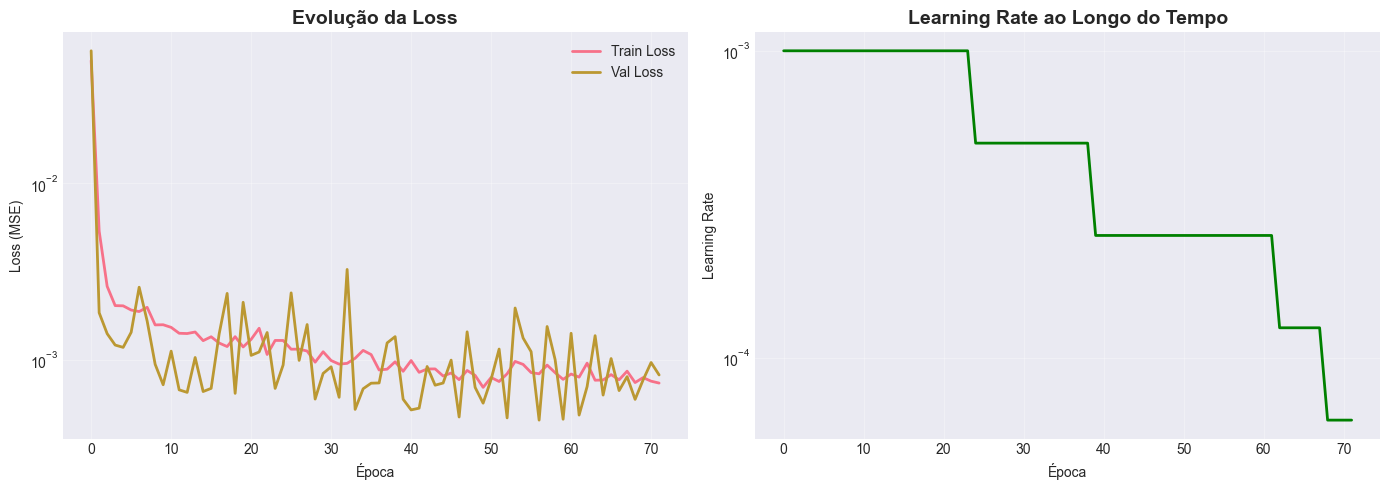

In [12]:
#Visualização do Treinamento

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Perdas de treino e validação
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Evolução da Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].semilogy()  # Escala log para melhor visualização

# Learning rate
axes[1].plot(history['learning_rate'], linewidth=2, color='green')
axes[1].set_title('Learning Rate ao Longo do Tempo', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Learning Rate')
axes[1].grid(True, alpha=0.3)
axes[1].semilogy()

plt.tight_layout()
plt.show()

In [15]:
#Otimização de Hiperparametros


def objective(trial):
    """
    Função objetivo para otimização de hiperparâmetros
    
    Args:
        trial: objeto trial do Optuna
    
    Returns:
        Loss de validação
    """
    # Definir espaço de busca
    hidden_size = trial.suggest_int('hidden_size', 32, 256, step=32)
    num_layers = trial.suggest_int('num_layers', 1, 4)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    
    print(f"Testando: hidden_size={hidden_size}, num_layers={num_layers}, "
          f"dropout={dropout:.3f}, lr={learning_rate:.5f}, batch_size={batch_size}")
    
    # Criar modelo com hiperparâmetros sugeridos
    model = LSTMModel(
        input_size=1,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)
    
    # Criar DataLoaders com novo batch_size
    train_loader_opt = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader_opt = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Treinador
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Treinar por algumas épocas
    model.train()
    for epoch in range(20): 
        # Treino
        model.train()
        for batch_X, batch_y in train_loader_opt:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        # Validação
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader_opt:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                predictions = model(batch_X)
                val_loss += criterion(predictions, batch_y).item()
        
        val_loss /= len(val_loader_opt)
        
        # Reportar para Optuna
        trial.report(val_loss, epoch)
        
        # Early stopping
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return val_loss


print("Iniciando busca por melhores hiperparâmetros...")

# Criar estudo Optuna
study = optuna.create_study(
    direction='minimize',
    study_name='lstm_stock_prediction',
    pruner=optuna.pruners.MedianPruner()
)

# Executar otimização
study.optimize(objective, n_trials=20, timeout=600)

print(f"Otimização concluída!")
print(f"Melhor trial: {study.best_trial.number}")
print(f"Melhor loss: {study.best_value:.6f}")
print(f"Melhores hiperparametros:")
for key, value in study.best_params.items():
    print(f"   • {key}: {value}")

# Criar modelo com melhores hiperparâmetros
best_params = study.best_params
best_model = LSTMModel(
    input_size=1,
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
).to(device)

print(best_model)

[I 2026-01-08 21:30:33,553] A new study created in memory with name: lstm_stock_prediction


Iniciando busca por melhores hiperparâmetros...
Testando: hidden_size=128, num_layers=4, dropout=0.190, lr=0.00904, batch_size=16


[I 2026-01-08 21:31:14,478] Trial 0 finished with value: 0.03446055126066009 and parameters: {'hidden_size': 128, 'num_layers': 4, 'dropout': 0.18977208183091993, 'learning_rate': 0.009035746097290114, 'batch_size': 16}. Best is trial 0 with value: 0.03446055126066009.


Testando: hidden_size=96, num_layers=2, dropout=0.142, lr=0.00038, batch_size=64


[I 2026-01-08 21:31:22,434] Trial 1 finished with value: 0.0007590036063144604 and parameters: {'hidden_size': 96, 'num_layers': 2, 'dropout': 0.142326417766087, 'learning_rate': 0.00037554365637829475, 'batch_size': 64}. Best is trial 1 with value: 0.0007590036063144604.


Testando: hidden_size=32, num_layers=2, dropout=0.278, lr=0.00159, batch_size=32


[I 2026-01-08 21:31:27,748] Trial 2 finished with value: 0.0006946434150449932 and parameters: {'hidden_size': 32, 'num_layers': 2, 'dropout': 0.2782231798228265, 'learning_rate': 0.001588749159869591, 'batch_size': 32}. Best is trial 2 with value: 0.0006946434150449932.


Testando: hidden_size=128, num_layers=4, dropout=0.340, lr=0.00026, batch_size=64


[I 2026-01-08 21:32:06,603] Trial 3 finished with value: 0.0017858633073046803 and parameters: {'hidden_size': 128, 'num_layers': 4, 'dropout': 0.33997787288662207, 'learning_rate': 0.0002591384089464751, 'batch_size': 64}. Best is trial 2 with value: 0.0006946434150449932.


Testando: hidden_size=96, num_layers=1, dropout=0.260, lr=0.00010, batch_size=64


[I 2026-01-08 21:32:10,326] Trial 4 finished with value: 0.005334204838921626 and parameters: {'hidden_size': 96, 'num_layers': 1, 'dropout': 0.2601259325708005, 'learning_rate': 0.0001039967123466977, 'batch_size': 64}. Best is trial 2 with value: 0.0006946434150449932.


Testando: hidden_size=64, num_layers=1, dropout=0.449, lr=0.00174, batch_size=16


[I 2026-01-08 21:32:19,377] Trial 5 finished with value: 0.0003233731804357376 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.4490084016749476, 'learning_rate': 0.001742365753836746, 'batch_size': 16}. Best is trial 5 with value: 0.0003233731804357376.


Testando: hidden_size=32, num_layers=2, dropout=0.186, lr=0.00737, batch_size=16


[I 2026-01-08 21:32:30,220] Trial 6 finished with value: 0.00033949853605008684 and parameters: {'hidden_size': 32, 'num_layers': 2, 'dropout': 0.18592302964266982, 'learning_rate': 0.007368724417821339, 'batch_size': 16}. Best is trial 5 with value: 0.0003233731804357376.


Testando: hidden_size=160, num_layers=1, dropout=0.145, lr=0.00562, batch_size=64


[I 2026-01-08 21:32:53,580] Trial 7 finished with value: 0.0009663128682101766 and parameters: {'hidden_size': 160, 'num_layers': 1, 'dropout': 0.1448786192787108, 'learning_rate': 0.005624511259183376, 'batch_size': 64}. Best is trial 5 with value: 0.0003233731804357376.


Testando: hidden_size=224, num_layers=3, dropout=0.221, lr=0.00027, batch_size=32


[I 2026-01-08 21:32:55,958] Trial 8 pruned. 


Testando: hidden_size=224, num_layers=3, dropout=0.383, lr=0.00036, batch_size=16


[I 2026-01-08 21:34:05,896] Trial 9 finished with value: 0.000640909841725564 and parameters: {'hidden_size': 224, 'num_layers': 3, 'dropout': 0.38252300100545056, 'learning_rate': 0.00035889624156616436, 'batch_size': 16}. Best is trial 5 with value: 0.0003233731804357376.


Testando: hidden_size=64, num_layers=1, dropout=0.497, lr=0.00161, batch_size=16


[I 2026-01-08 21:34:19,808] Trial 10 finished with value: 0.0029549459189487 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.49746784400244726, 'learning_rate': 0.0016138937713108996, 'batch_size': 16}. Best is trial 5 with value: 0.0003233731804357376.


Testando: hidden_size=32, num_layers=2, dropout=0.439, lr=0.00346, batch_size=16


[I 2026-01-08 21:34:20,674] Trial 11 pruned. 


Testando: hidden_size=32, num_layers=1, dropout=0.359, lr=0.00290, batch_size=16


[I 2026-01-08 21:34:22,061] Trial 12 pruned. 


Testando: hidden_size=64, num_layers=2, dropout=0.494, lr=0.00092, batch_size=16


[I 2026-01-08 21:34:22,940] Trial 13 pruned. 


Testando: hidden_size=64, num_layers=3, dropout=0.106, lr=0.00080, batch_size=16


[I 2026-01-08 21:34:25,734] Trial 14 pruned. 


Testando: hidden_size=160, num_layers=1, dropout=0.420, lr=0.00640, batch_size=16


[I 2026-01-08 21:34:54,479] Trial 15 finished with value: 0.00019882622837030794 and parameters: {'hidden_size': 160, 'num_layers': 1, 'dropout': 0.4197861865147214, 'learning_rate': 0.0063951010976083964, 'batch_size': 16}. Best is trial 15 with value: 0.00019882622837030794.


Testando: hidden_size=192, num_layers=1, dropout=0.416, lr=0.00361, batch_size=32


[I 2026-01-08 21:34:56,358] Trial 16 pruned. 


Testando: hidden_size=256, num_layers=1, dropout=0.438, lr=0.00175, batch_size=16


[I 2026-01-08 21:35:24,508] Trial 17 finished with value: 0.0007688189240676971 and parameters: {'hidden_size': 256, 'num_layers': 1, 'dropout': 0.43773655649701915, 'learning_rate': 0.0017498707156152161, 'batch_size': 16}. Best is trial 15 with value: 0.00019882622837030794.


Testando: hidden_size=160, num_layers=1, dropout=0.317, lr=0.00562, batch_size=16


[I 2026-01-08 21:35:52,854] Trial 18 finished with value: 0.0023875308494704464 and parameters: {'hidden_size': 160, 'num_layers': 1, 'dropout': 0.3173454040097599, 'learning_rate': 0.005621068843865523, 'batch_size': 16}. Best is trial 15 with value: 0.00019882622837030794.


Testando: hidden_size=192, num_layers=2, dropout=0.403, lr=0.00072, batch_size=32


[I 2026-01-08 21:37:07,158] Trial 19 finished with value: 0.0006853816691242779 and parameters: {'hidden_size': 192, 'num_layers': 2, 'dropout': 0.4033260352555709, 'learning_rate': 0.0007221734150684875, 'batch_size': 32}. Best is trial 15 with value: 0.00019882622837030794.


Otimização concluída!
Melhor trial: 15
Melhor loss: 0.000199
Melhores hiperparametros:
   • hidden_size: 160
   • num_layers: 1
   • dropout: 0.4197861865147214
   • learning_rate: 0.0063951010976083964
   • batch_size: 16
LSTMModel(
  (lstm): LSTM(1, 160, batch_first=True)
  (dropout): Dropout(p=0.4197861865147214, inplace=False)
  (fc): Linear(in_features=160, out_features=1, bias=True)
)


Época   1/100 | Train Loss: 0.021888 | Val Loss: 0.009027 | LR: 0.001000
Época   2/100 | Train Loss: 0.001960 | Val Loss: 0.006347 | LR: 0.001000
Época   3/100 | Train Loss: 0.001791 | Val Loss: 0.000600 | LR: 0.001000
Época   4/100 | Train Loss: 0.001441 | Val Loss: 0.000678 | LR: 0.001000
Época   5/100 | Train Loss: 0.001390 | Val Loss: 0.000878 | LR: 0.001000
Época   6/100 | Train Loss: 0.001482 | Val Loss: 0.000946 | LR: 0.001000
Época   7/100 | Train Loss: 0.000946 | Val Loss: 0.001253 | LR: 0.001000
Época   8/100 | Train Loss: 0.001181 | Val Loss: 0.000703 | LR: 0.001000
Época   9/100 | Train Loss: 0.000994 | Val Loss: 0.001986 | LR: 0.000500
Época  10/100 | Train Loss: 0.000827 | Val Loss: 0.001139 | LR: 0.000500
Época  11/100 | Train Loss: 0.000849 | Val Loss: 0.002636 | LR: 0.000500
Época  12/100 | Train Loss: 0.000734 | Val Loss: 0.000736 | LR: 0.000500
Época  13/100 | Train Loss: 0.000790 | Val Loss: 0.002208 | LR: 0.000500
Época  14/100 | Train Loss: 0.000774 | Val Loss: 0.

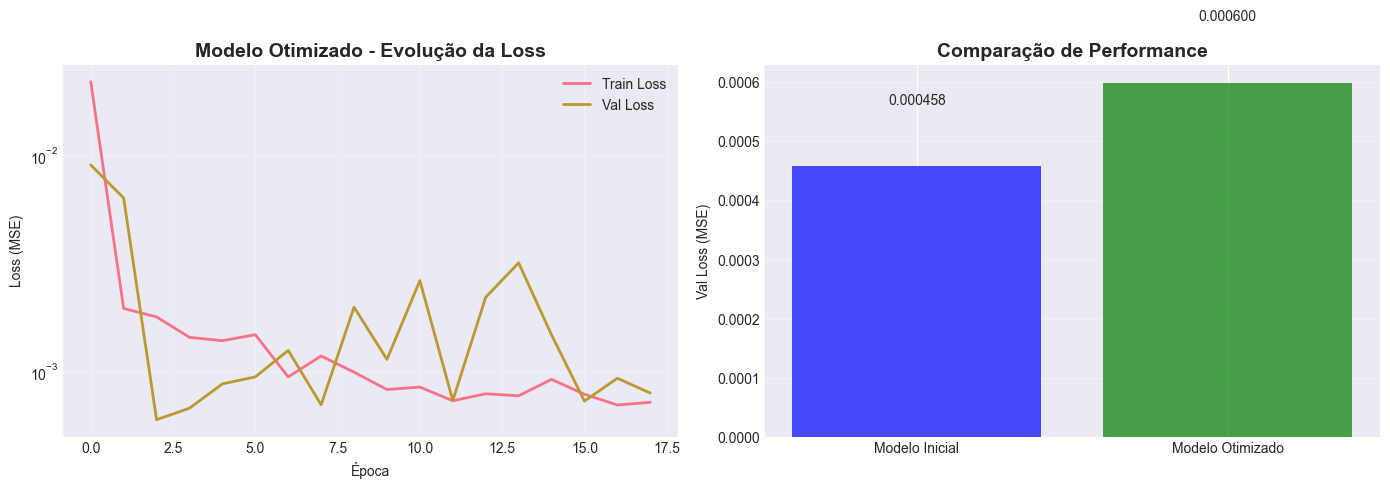

In [16]:
#Treinar Modelo Otimizado

# Criar DataLoaders com melhor batch_size
batch_size_opt = best_params['batch_size']
train_loader_opt = DataLoader(train_dataset, batch_size=batch_size_opt, shuffle=True)
val_loader_opt = DataLoader(val_dataset, batch_size=batch_size_opt, shuffle=False)

# Treinar modelo otimizado
trainer_opt = ModelTrainer(best_model, train_loader_opt, val_loader_opt, device)
history_opt = trainer_opt.train(epochs=100, patience=15)

# Comparar modelos
print(f"Modelo inicial - Val Loss: {checkpoint['val_loss']:.6f}")
print(f"Modelo otimizado - Val Loss: {min(history_opt['val_loss']):.6f}")

# Visualizar treinamento do modelo otimizado
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_opt['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history_opt['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Modelo Otimizado - Evolução da Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].semilogy()

# Comparação de val loss
axes[1].bar(['Modelo Inicial', 'Modelo Otimizado'], 
            [checkpoint['val_loss'], min(history_opt['val_loss'])],
            color=['blue', 'green'], alpha=0.7)
axes[1].set_title('Comparação de Performance', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Val Loss (MSE)')
axes[1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate([checkpoint['val_loss'], min(history_opt['val_loss'])]):
    axes[1].text(i, v + 0.0001, f'{v:.6f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

MAE (Mean Absolute Error): $0.61
RMSE (Root Mean Square Error): $0.79
MAPE (Mean Absolute Percentage Error): 2.01%
MAE (normalizado): 0.019394


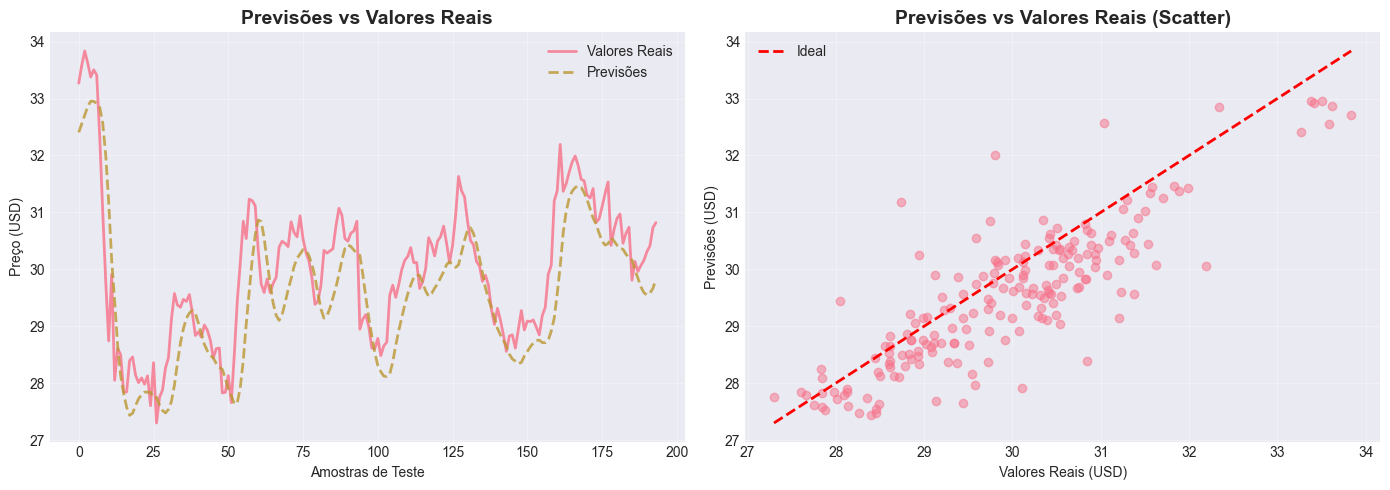

In [23]:
#Avaliação do Modelo

class ModelEvaluator:
    """Classe para avaliação do modelo"""
    
    def __init__(self, model, test_loader, scaler, device):
        self.model = model
        self.test_loader = test_loader
        self.scaler = scaler
        self.device = device
    
    def evaluate(self):
        """Avalia o modelo no conjunto de teste"""
        self.model.eval()
        
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            for batch_X, batch_y in self.test_loader:
                batch_X = batch_X.to(self.device)
                
                predictions = self.model(batch_X)
                
                all_predictions.extend(predictions.cpu().numpy())
                all_targets.extend(batch_y.numpy())
        
        # Converter para numpy arrays
        predictions_np = np.array(all_predictions).reshape(-1, 1)
        targets_np = np.array(all_targets).reshape(-1, 1)
        
        # Desnormalizar as previsões
        predictions_actual = self.scaler.inverse_transform(predictions_np)
        targets_actual = self.scaler.inverse_transform(targets_np)
        
        return predictions_actual, targets_actual
    
    def calculate_metrics(self, predictions, targets):
        """Calcula métricas de avaliação"""
        # Métricas na escala original (dólares)
        mae = mean_absolute_error(targets, predictions)
        rmse = np.sqrt(mean_squared_error(targets, predictions))
        mape = mean_absolute_percentage_error(targets, predictions) * 100
        
        # Métricas na escala normalizada (para comparação)
        predictions_norm = self.scaler.transform(predictions)
        targets_norm = self.scaler.transform(targets)
        mae_norm = mean_absolute_error(targets_norm, predictions_norm)
        
        return {
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'MAE_norm': mae_norm
        }


# Criar avaliador
evaluator = ModelEvaluator(best_model, test_loader, scaler, device)

# Fazer previsões
predictions, targets = evaluator.evaluate()

# Calcular métricas
metrics = evaluator.calculate_metrics(predictions, targets)

print(f"MAE (Mean Absolute Error): ${metrics['MAE']:.2f}")
print(f"RMSE (Root Mean Square Error): ${metrics['RMSE']:.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {metrics['MAPE']:.2f}%")
print(f"MAE (normalizado): {metrics['MAE_norm']:.6f}")

# Visualizar previsões vs valores reais - APENAS 2 GRÁFICOS
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Previsões vs Valores Reais
axes[0].plot(targets, label='Valores Reais', linewidth=2, alpha=0.8)
axes[0].plot(predictions, label='Previsões', linewidth=2, alpha=0.8, linestyle='--')
axes[0].set_title('Previsões vs Valores Reais', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Amostras de Teste')
axes[0].set_ylabel('Preço (USD)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Scatter plot
axes[1].scatter(targets, predictions, alpha=0.5)
axes[1].plot([targets.min(), targets.max()], 
             [targets.min(), targets.max()], 
             'r--', linewidth=2, label='Ideal')
axes[1].set_title('Previsões vs Valores Reais (Scatter)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Valores Reais (USD)')
axes[1].set_ylabel('Previsões (USD)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()